# Extended CVC Electrogardiogram Analysis and ECG-RF Completion document

Canadian VIGOUR Centre: Electrocardiogram Analysis and ECG-RF Completion

* [Electrocardiogram Analysis and ECG-RF Completion.pdf](https://swift-yeg.cloud.cybera.ca:8080/v1/AUTH_e3b719b87453492086f32f5a66c427cf/physionet_2020/Documents/Electrocardiogram%20Analysis%20and%20ECG-RF%20Completion.pdf)

How can we turn the procedures and steps defined in this document into a process for feature extraction on digital ECGs?

The nine labels asked of us in the Physionet 2020 challenge are:

1. AF - Atrial fibrillation
2. I-AVB - First-degree atrioventricular block
3. **LBBB - Left bundle branch block**
4. Normal - Normal sinus rhythm
5. PAC - Premature atrial complex
6. PVC - Premature ventricular complex
7. **RBBB - Right bundle branch block**
8. STD - ST-segment depression
9. STE - ST-segment elevation


In [19]:
import os
from glob import glob
from functools import partial
from multiprocessing import Pool
from subprocess import DEVNULL, run
from tempfile import TemporaryDirectory

import wfdb

In [20]:
record_names = tuple(sorted(fn.split(".hea")[0] for fn in glob("Training_WFDB/*.hea")))

In [38]:
def _extract_signal_features(sig_idx, temp_dir="", record=None):
    r_pth = os.path.join(temp_dir, record.record_name)
    try:
        run(
            f"ecgpuwave -r {record.record_name} -a atr{sig_idx} -s {sig_idx}",
            cwd=temp_dir,
            shell=True,
            check=True,
            stdout=DEVNULL,
            stderr=DEVNULL
        )
        return sig_idx, wfdb.rdann(r_pth, f"atr{sig_idx}")
    except Exception as e:
        print(e)
        return None, None

def get_ecgpuwave_annotations(r):
    if r.p_signal is None:
        r.dac(inplace=True)
    seq_len, num_signals = r.p_signal.shape
    with TemporaryDirectory() as temp_dir:
        if r.d_signal is None:
            r.adc(inplace=True) # convert to d_signal (digital)
        r.wrsamp(write_dir=temp_dir)
        r.dac(inplace=True) # convert back to p_signal (physical/analog)
        
        worker_fn = partial(_extract_signal_features, temp_dir=temp_dir, record=r)
        signals = list(range(num_signals))
        
        try:
            with Pool(len(os.sched_getaffinity(0))) as p:
                annotations = dict(p.imap(worker_fn, signals))
        except Exception:
            annotations = dict([worker_fn(signal) for signal in signals])
    return annotations

Writing file A0003.mat with 24 empty leading bytes


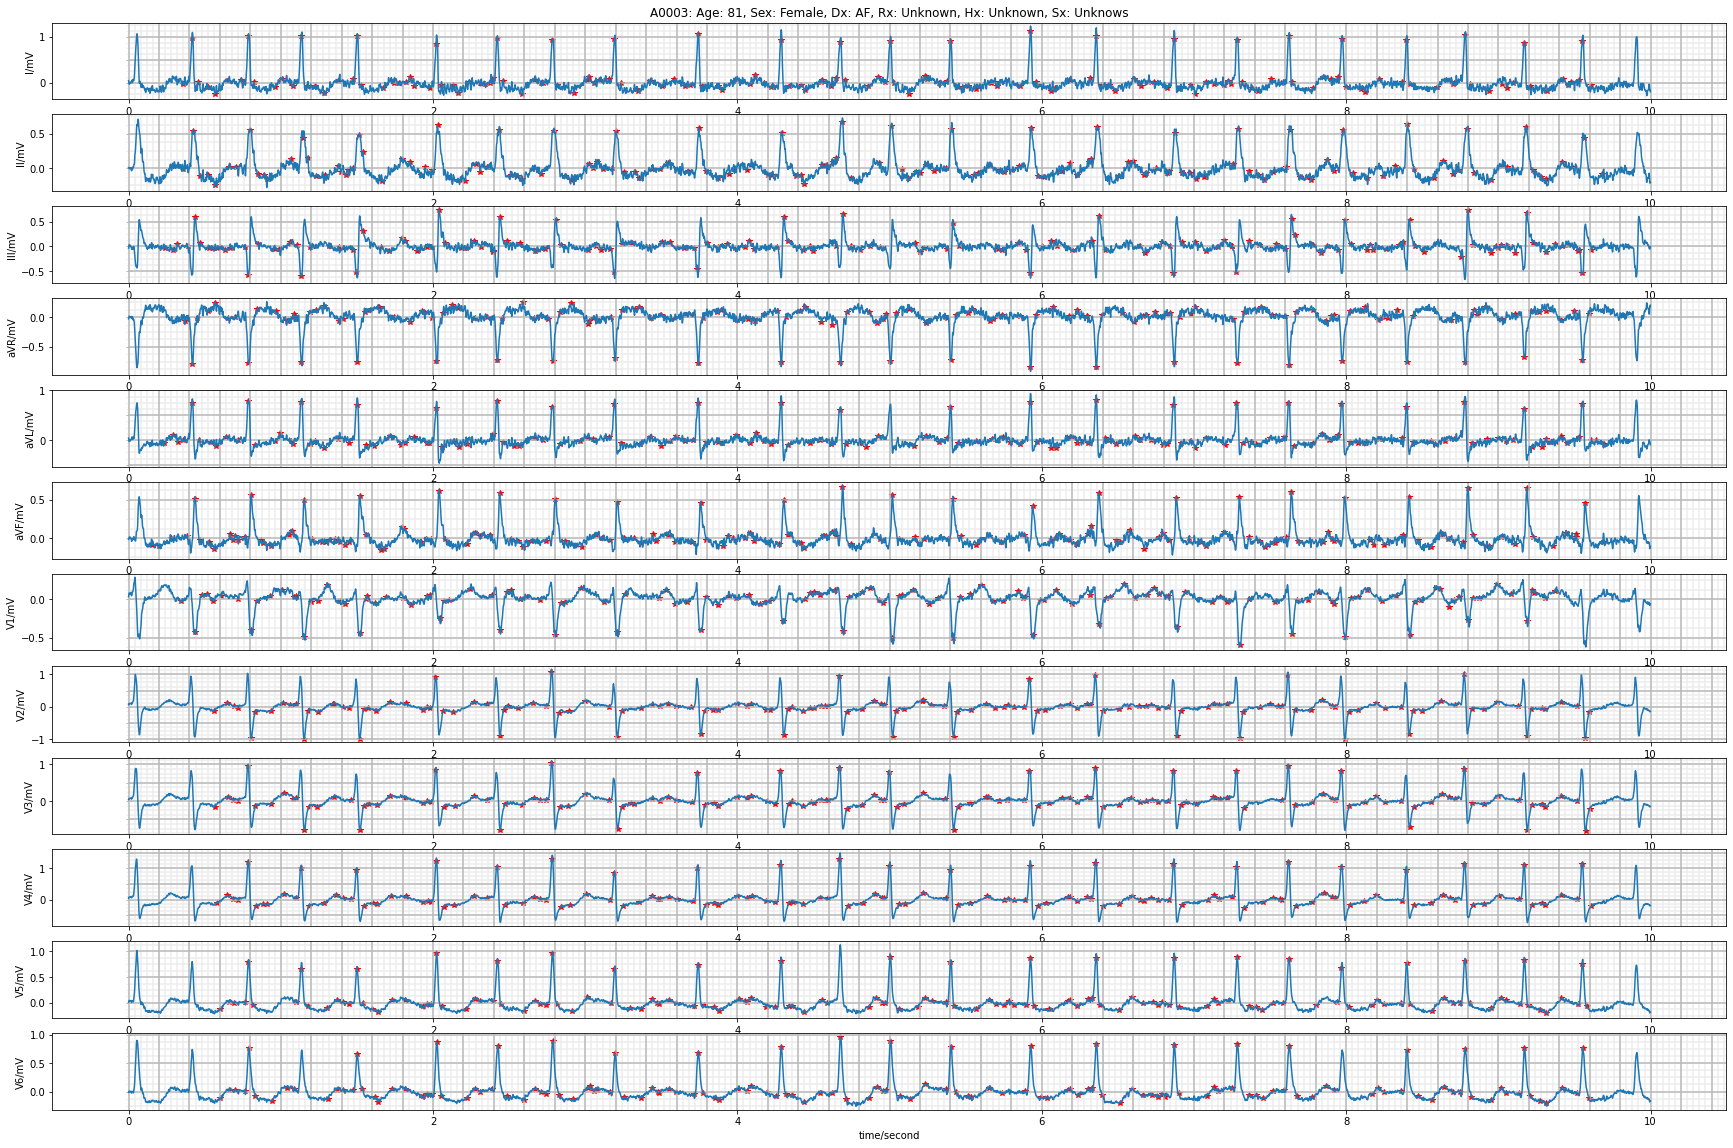

In [65]:
record = wfdb.rdrecord(record_names[2])
# wfdb.plot_wfdb(
#     record=record, figsize=(20, 10),
#     time_units="seconds", title="{}: {}".format(record.record_name, ", ".join(record.comments)))

annotations = get_ecgpuwave_annotations(record)

wfdb.plot.plot_items(
    signal=record.p_signal,
    ann_samp=[a.sample for a in annotations.values()],
    fs=record.fs,
    time_units="seconds",
    sig_name=record.sig_name,
    sig_units=record.units,
    ecg_grids="all",
    title="{}: {}".format(record.record_name, ", ".join(record.comments)),
    figsize=(30, 20),
)

## Complete left bundle branch block (LBBB)

* QRS duration must be greater than equal to 130 ms
* There is a terminal broad S in V1
* Broad notched or slurred R wave in leads I, aVL, V5, and V6
* R peak time greater than 60 ms in leads V5 and V6 but normal in leads V1, V2, V3
* if complete LBBB is present, do not evaluate ST segment deviation or QRS score


## Complete right bundle branch block (RBBB)

* QRS duration must be greater than or equal to 120 ms
* There is an rsr, rsR, or rSR in leads V1 or V2
* The R or r deflection is usually wider than the initial R wave
* S wave of greater duration than R wave or greater than 40ms in leads I and V6
* Normal R peak time in leads V5 and V6 but 50ms in lead V1

## Left anterior fasicular block (LAHB)
* Extreme left axis deviation of -45 to -90 degrees
* qR pattern in lead aVL
* R-peak time in lead aVL of 45 ms or more
* Absense of any one of the criteria for LVH or complete LBBB and QRS duration less than 120 ms

## Left posterior fascicular block (LPHB)
* Extreme right axis deviation of at least +90 to 180 degrees
* rS pattern in leads I and aVL
* qR pattern in leads III and aVF
* Absense of RVH and QRS duration less than 120 ms

## Left ventricular hypertrophy (LVH)
One of the following must be met:

- **Sokolow-Lyon**: Measure the amplitude of the S wave in V1 and the amplitude of the R wave in V5 or V6 (whichever is larger). The sum of the amplitudes must be greater than equal to 35 mm or R wave in leads V5 or V6 is greater than 26 mm.

- **Cornell Voltage**: Measure the amplitude of the S wave in V3 and the amplitude of the R wave in aVL.
    - If the patient is male, the sum of the amplitudes must be greater than equal to 28 mm.
    - If the patient is female, the sum of the amplitudes must be greater than equal to 20 mm.
    - If the gender is not identified on the ECG, assume the patient is male.
    - In LBBB, LVH indicated if QRS duration is greater than approximately 155ms, as well as precordial lead voltage criteria of LVH.

## Right ventricular hypertrophy (RVH)
Simplified version of the Butler-Leggett Criteria. The formula (R or R' in V1 or V2) + (S in I or V6) - (S in V1) greater than or equal to 7mm) is used to desginate patients as having RVH. Choose the waveforms with the greatest amplitudes.

## Wolff Parkinson White pattern (WPW)
The PR interval must be less than 130 ms during sinus rhythm and the initial part of the QRS has a slurred upstroke (delta wave).

## Low voltage
The overall QRS amplitude in each limb lead is less than or equal to 5mm and is less than or equal to 10mm in each precordial lead.

## Ventricular paced
Electronic spikes followed by QRS > 140 ms. Pacing is considered as a confounding factor only if ventricular pacing is involved. Atrial pacing is not considered as a confounding factor.

## Incomplete ECG
Standard 12 lead ECGs are classified as being incomplete if:
* Over two leads are missing (exception, a single lead missing that could alter interpretation)
* Lead misplacement that is not easily identified
* Right sided rather than left sided precordial leads
* Derived 12 lead ECG 3 lead acquisition


## Poor quality ECG recording
ECGs are classified as poor quality if they were unreadable due to the following:
* Baseline wander in greater than or equal to 2 leads of the same MI region
* Excessive artifact in greater than or equal to 2 leads of the same MI region
* Recording too light or broken throughout to see waveforms clearly
* No grid lines visible and no proper calibration marker on Xerox copy

## General MI definitions
Definitions of abnormal Q or Q equivalent used for prior or acute MI diagnosis. At a gain of 10mm/mV, a Q or R waveform should be considered present if it has amplitude of greater than 0.25mm or 0.025mV. When waveforms vary among multiple cardiac cycles, the variety that are present in over 50% of the cycles should be considered as the dominant waveform.

## Prior MI
* Consider prior MI on baseline ECG only in leads without ST elevation, including ST depression in leads V1-V3.
* Must meet Selvester MI screening criteria in one of the following locations. MI Screen Criteria used for prior MI diagnosis are as follows:
  - Anterior
: V2 any Q wave or small R (less than or equal to 10ms and less than or equal to 1mm)
  - Inferior
: aVF Q greater than or equal to 30 ms
  - Lateral
: Q greater than or equal to 30 ms in both Lead I and aVL
  - Apical
: Q greater than or equal to 30 ms in at least 2 of the leads V4, V5, V6
  - Posterior
: V1 R greater than or equal to 40 ms
* In the case where Q waves are present, but the ST segment deviation does not meet the strict criteria for epicardial injury, the acute MI versus prior MI determination should be based on the evolution of the ST segment and T wave changes over subsequent ECGs